In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet50 import ResNet50
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [2]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

















Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds

Your Kaggle username: rudraganeshr

Your Kaggle Key: ··········



100%|██████████| 2.70G/2.70G [00:12<00:00, 240MB/s]


In [3]:
train ='/content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
validation_dir = '/content/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [4]:
import glob
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [5]:
train_samples =get_files(train)
num_classes=len(glob.glob(train+"/*"))
test_samples=get_files(validation_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

38 Classes

70295 Train images

17572 Test images


In [6]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
img_width,img_height =128,128
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train,
                                target_size=(img_width,img_height),batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(validation_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)

Found 70295 images belonging to 38 classes.

Found 17572 images belonging to 38 classes.


In [7]:
od.download('https://www.kaggle.com/datasets/keras/resnet50')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds

Your Kaggle username: rudraganeshr

Your Kaggle Key: ··········



100%|██████████| 174M/174M [00:02<00:00, 87.5MB/s]


In [8]:
model = Sequential()
#vgg-16 , 80% accuracy with 100 epochs
# model.add(VGG16(input_shape=(224,224,3),pooling='avg',classes=1000,weights=vgg16_weights_path))
#resnet-50 , 87% accuracy with 100 epochs
model.add(ResNet50(include_top=False,input_tensor=None,input_shape=(128,128,3),pooling='avg',classes=2,weights="imagenet"))
model.add(Flatten())

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(38, activation='sigmoid'))

# model.layers[0].trainable = False
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 2048)              23587712  

                                                                 

 flatten (Flatten)           (None, 2048)              0         

                                                                 

 dropout (Dropout)           (None, 2048)              0         

                                                                 

 batch_normalization (BatchN  (None, 2048)             8192      

 ormalization)                                                   

                                                                 

 dense (Dense)               (None, 256)               524544    

                                                                 

 dropout_1 (Dropout)         (None, 256)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
history = model.fit(train_generator,validation_data=test_generator,epochs=10,shuffle=True)

Epoch 1/10

2197/2197 [==============================] - 547s 227ms/step - loss: 0.7668 - accuracy: 0.7785 - val_loss: 2.4916 - val_accuracy: 0.4910

Epoch 2/10

2197/2197 [==============================] - 491s 224ms/step - loss: 0.2988 - accuracy: 0.9094 - val_loss: 1.8607 - val_accuracy: 0.6098

Epoch 3/10

2197/2197 [==============================] - 493s 225ms/step - loss: 0.2241 - accuracy: 0.9311 - val_loss: 4.3888 - val_accuracy: 0.3545

Epoch 4/10

2197/2197 [==============================] - 485s 221ms/step - loss: 0.1788 - accuracy: 0.9452 - val_loss: 1.7660 - val_accuracy: 0.6300

Epoch 5/10

2197/2197 [==============================] - 491s 224ms/step - loss: 0.1501 - accuracy: 0.9545 - val_loss: 0.2466 - val_accuracy: 0.9262

Epoch 6/10

2197/2197 [==============================] - 488s 222ms/step - loss: 0.1346 - accuracy: 0.9591 - val_loss: 1.1936 - val_accuracy: 0.7244

Epoch 7/10

2197/2197 [==============================] - 485s 221ms/step - loss: 0.1119 - accuracy: 

550/550 [==============================] - 38s 68ms/step


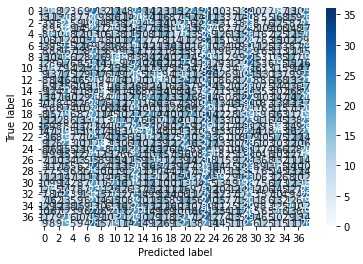

In [10]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [11]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print(report)

550/550 [==============================] - 38s 68ms/step

                                                    precision    recall  f1-score   support



                                Apple___Apple_scab       0.03      0.02      0.03       504

                                 Apple___Black_rot       0.02      0.02      0.02       497

                          Apple___Cedar_apple_rust       0.04      0.03      0.03       440

                                   Apple___healthy       0.02      0.03      0.03       502

                               Blueberry___healthy       0.03      0.02      0.02       454

          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       421

                 Cherry_(including_sour)___healthy       0.03      0.02      0.02       456

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.02      0.03      0.02       410

                       Corn_(maize)___Common_rust_       0.03      0.03      0.03       477

          

In [96]:
model.save('res_model.h5')

In [103]:
img='/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864_flipTB.JPG'

In [104]:
def predict_disease(test_image):
  img = cv2.imread(test_image)
  img = img / 255.0
  img = cv2.resize(img, (128, 128))
  img = img.reshape(1,128,128,3)
  prediction = model.predict(img)
  pred_class = np.argmax(prediction, axis = -1)
  return pred_class

In [105]:
pred=predict_disease(img)
d=pred[0]

1/1 [==============================] - 0s 28ms/step


In [106]:
Plant_disease = [  'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',  'Tomato___healthy']


In [107]:
Plant_disease[d]

'Potato___healthy'

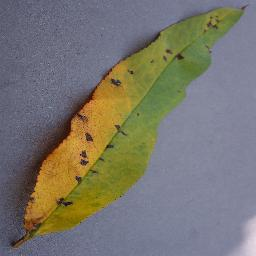

In [102]:
from IPython.display import Image
Image(img)